#Extraction, transformation and analysis of a data set Gaming.stackexchange.com

In the following work, I used the Stack Exchange Data Dump available on the website: https://archive.org/details/stackexchange.
Stack Exchange is a website where users can ask questions and provide answers in a variety of fields. In my analysis, I used data on forum posts about computer games.
First, I read the data in xml format and parsed it using com.databricks: spark-xml_2.12: 0.12.0 library.
After preparing the Data Frame, I analyzed the data based on the adopted business problem.

In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = SparkSession.builder \
    .appName('DataFrame') \
    .master('local[*]') \
    .getOrCreate()

In [0]:
%sh
sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvc6-plugins-gtk libgvpr2 liblab-gamut1 libpathplan4 libpython3-dev
  libxdot4
Suggested packages:
  graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgraphviz-dev
  libgts-0.7-5 libgts-bin libgvc6 libgvc6-plugins-gtk libgvpr2 liblab-gamut1
  libpathplan4 libpython3-dev libxdot4 pkg-config python3-dev
0 upgraded, 17 newly installed, 0 to remove and 21 not upgraded.
Need to get 2,849 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 fonts-liberation all 1:1.07.4-11 [822 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libann0 amd64 1.1.2+doc-7build1 [26.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal

Architecture' size too small for label


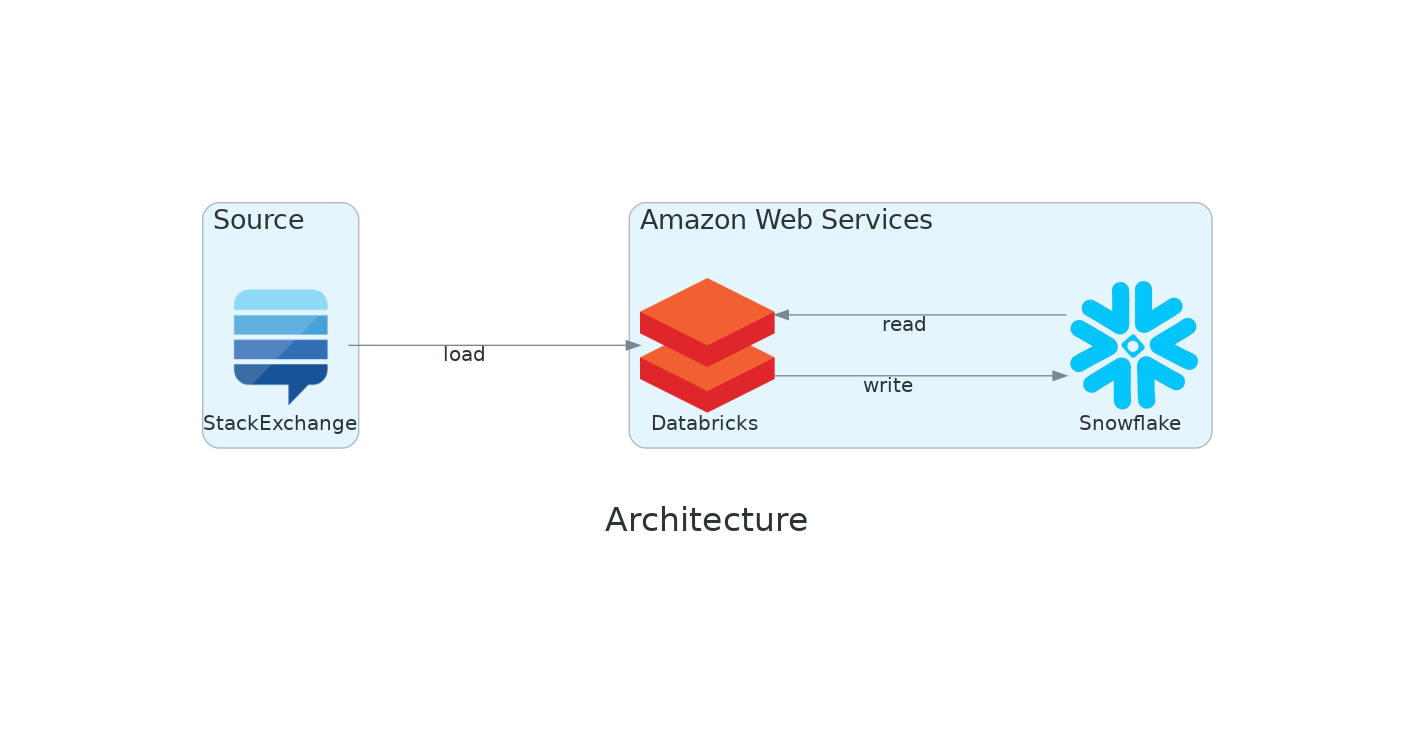

In [0]:
from urllib.request import urlretrieve
from diagrams import Cluster, Diagram, Edge
from diagrams.onprem.analytics import Databricks
from diagrams.saas.analytics import Snowflake
from diagrams.custom import Custom

graph_attr = {
    "fontsize": "25",
    "ratio" : "auto",
    "compund": "True"
}
cluster_attr = {
    "fontsize": "20"
}
node_attr = {
    "fontsize": "15"
}
edge_attr = {
    "minlen": "4.0"
}

with Diagram("\nArchitecture", filename="diagram", show=False, 
        graph_attr=graph_attr, edge_attr=edge_attr, node_attr=node_attr) as diag:

    with Cluster("Amazon Web Services", graph_attr=cluster_attr):
        databricks = Databricks("Databricks ")
        snowflake = Snowflake("Snowflake ")
  
    with Cluster("Source", graph_attr=cluster_attr):
        stackexchange_url = "https://stackoverflow.design/assets/img/logos/se/se-icon.png"
        stackexchange_icon = "se-icon.png"
 
        urlretrieve(stackexchange_url, stackexchange_icon)
 
        stackexchange= Custom("StackExchange", stackexchange_icon )
    
stackexchange >> Edge(xlabel="load",  fontsize= "15") >> databricks         
databricks  >> Edge(xlabel="write", fontsize= "15") >> snowflake >> Edge(xlabel="read", fontsize= "15") >>  databricks
diag


In [0]:
# Create a folder for xml files and a folder for parquet files.
dbutils.fs.mkdirs("/FileStore/tables/GamingXML")
dbutils.fs.mkdirs("/FileStore/tables/GamingPRQ")

Out[9]: True

In [0]:
display(dbutils.fs.ls("/FileStore/tables"))

path,name,size
dbfs:/FileStore/tables/DataScience/,DataScience/,0
dbfs:/FileStore/tables/GamingPRQ/,GamingPRQ/,0
dbfs:/FileStore/tables/GamingXML/,GamingXML/,0
dbfs:/FileStore/tables/IOT/,IOT/,0
dbfs:/FileStore/tables/adult.data,adult.data,3974305
dbfs:/FileStore/tables/movies.dat,movies.dat,500835


In [0]:
%fs rm -r /FileStore/tables/Gaming/

res6: Boolean = true

## 1. Loading files from the stack exchange website

In [0]:
%sh
wget https://archive.org/download/stackexchange/gaming.stackexchange.com.7z

--2022-01-26 05:49:17--  https://archive.org/download/stackexchange/gaming.stackexchange.com.7z
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia800107.us.archive.org/27/items/stackexchange/gaming.stackexchange.com.7z [following]
--2022-01-26 05:49:18--  https://ia800107.us.archive.org/27/items/stackexchange/gaming.stackexchange.com.7z
Resolving ia800107.us.archive.org (ia800107.us.archive.org)... 207.241.232.17
Connecting to ia800107.us.archive.org (ia800107.us.archive.org)|207.241.232.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207720360 (198M) [application/x-7z-compressed]
Saving to: ‘gaming.stackexchange.com.7z’

     0K .......... .......... .......... .......... ..........  0% 2.42M 82s
    50K .......... .......... .......... .......... ..........  0% 2.15M 87s
   100K .......... .......... .......... 

In [0]:
%sh ls

conf
eventlogs
gaming.stackexchange.com.7z
ganglia
logs
metastore_db
preload_class.lst


In [0]:
%sh pwd

/databricks/driver


In [0]:
%sh sudo apt-get install -y p7zip-rar

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  p7zip p7zip-full
The following NEW packages will be installed:
  p7zip p7zip-full p7zip-rar
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 1,589 kB of archives.
After this operation, 6,014 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip amd64 16.02+dfsg-7build1 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip-full amd64 16.02+dfsg-7build1 [1,187 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 p7zip-rar amd64 16.02-3build1 [44.8 kB]
debconf: delaying package configuration, since apt-utils is not installed
Fetched 1,589 kB in 2s (923 kB/s)
Selecting previously unselected package p7zip.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading data

In [0]:
%sh mkdir GamingTmp
ls

GamingTmp
conf
eventlogs
gaming.stackexchange.com.7z
ganglia
logs
metastore_db
preload_class.lst


In [0]:
%sh
7z x gaming.stackexchange.com.7z -o/databricks/driver/GamingTmp


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz (406F1),ASM,AES-NI)

Scanning the drive for archives:
1 file, 207720360 bytes (199 MiB)

Extracting archive: gaming.stackexchange.com.7z
--
Path = gaming.stackexchange.com.7z
Type = 7z
Physical Size = 207720360
Headers Size = 344
Method = BZip2
Solid = +
Blocks = 7

Everything is Ok

Files: 8
Size:       1176757432
Compressed: 207720360


In [0]:
dbutils.fs.mv("file:/databricks/driver/GamingTmp", "dbfs:/FileStore/tables/GamingXML", True)

Out[19]: True

In [0]:
display(dbutils.fs.ls("/FileStore/tables/GamingXML"))

path,name,size
dbfs:/FileStore/tables/GamingXML/Badges.xml,Badges.xml,47820438
dbfs:/FileStore/tables/GamingXML/Comments.xml,Comments.xml,98011065
dbfs:/FileStore/tables/GamingXML/PostHistory.xml,PostHistory.xml,523666934
dbfs:/FileStore/tables/GamingXML/PostLinks.xml,PostLinks.xml,3849407
dbfs:/FileStore/tables/GamingXML/Posts.xml,Posts.xml,281873182
dbfs:/FileStore/tables/GamingXML/Tags.xml,Tags.xml,459081
dbfs:/FileStore/tables/GamingXML/Users.xml,Users.xml,65065590
dbfs:/FileStore/tables/GamingXML/Votes.xml,Votes.xml,156011735


## 2. Preparation of the Data Frame

Tables downloaded from the Stack Exchange website are in XML format. First I will load the files into Data Frame using the XML parsing library: com.databricks: spark-xml
Then I will save the files in Parquet format.

In [0]:
BadgesReadPath = "/FileStore/tables/GamingXML/Badges.xml"
CommentsReadPath = "/FileStore/tables/GamingXML/Comments.xml"
PostHistoryReadPath = "/FileStore/tables//GamingXML/PostHistory.xml"
PostLinksReadPath = "/FileStore/tables//GamingXML/PostLinks.xml"
PostsReadPath = "/FileStore/tables//GamingXML/Posts.xml"
TagsReadPath = "/FileStore/tables/GamingXML/Tags.xml"
UsersReadPath = "/FileStore/tables/GamingXML/Users.xml"
VotesReadPath ="/FileStore/tables/GamingXML/Votes.xml"

In [0]:
BadgesWritePath = "/FileStore/tables/GamingPRQ/Badges.parquet"
CommentsWritePath = "/FileStore/tables/GamingPRQ/Comments.parquet"
PostHistoryWritePath = "/FileStore/tables//GamingPRQ/PostHistory.parquet"
PostLinksWritePath = "/FileStore/tables//GamingPRQ/PostLinks.parquet"
PostsWritePath = "/FileStore/tables//GamingPRQ/Posts.parquet"
TagsWritePath = "/FileStore/tables/GamingPRQ/Tags.parquet"
UsersWritePath = "/FileStore/tables/GamingPRQ/Users.parquet"
VotesWritePath ="/FileStore/tables/GamingPRQ/Votes.parquet"

In [0]:
Badges = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(BadgesReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", BadgesWritePath) \
.save()

In [0]:
display(dbutils.fs.ls("/FileStore/tables/GamingPRQ"))

path,name,size
dbfs:/FileStore/tables/GamingPRQ/Badges.parquet/,Badges.parquet/,0


In [0]:
BadgesDF = spark.read.parquet(BadgesWritePath)
display(BadgesDF)

_Class,_Date,_Id,_Name,_TagBased,_UserId
3,2010-07-07T19:08:45.087+0000,1,Autobiographer,false,2
3,2010-07-07T19:08:45.087+0000,2,Autobiographer,false,5
3,2010-07-07T19:08:45.087+0000,3,Autobiographer,false,6
3,2010-07-07T19:08:45.087+0000,4,Autobiographer,false,7
3,2010-07-07T19:08:45.087+0000,5,Autobiographer,false,9
3,2010-07-07T19:08:45.087+0000,6,Autobiographer,false,11
3,2010-07-07T19:08:45.087+0000,7,Autobiographer,false,12
3,2010-07-07T19:08:45.087+0000,8,Autobiographer,false,13
3,2010-07-07T19:08:45.087+0000,9,Autobiographer,false,14
3,2010-07-07T19:08:45.087+0000,10,Autobiographer,false,15


In [0]:
BadgesDF.printSchema()

root
 |-- _Class: long (nullable = true)
 |-- _Date: timestamp (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _Name: string (nullable = true)
 |-- _TagBased: boolean (nullable = true)
 |-- _UserId: long (nullable = true)



In [0]:
Comments = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(CommentsReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", CommentsWritePath) \
.save()

PostHistory = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(PostHistoryReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", PostHistoryWritePath) \
.save()

PostLinks = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(PostLinksReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", PostLinksWritePath) \
.save()

Posts = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(PostsReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", PostsWritePath) \
.save()

Tags = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(TagsReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", TagsWritePath) \
.save()

Users = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(UsersReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", UsersWritePath) \
.save()

Votes = spark\
.read.format("com.databricks.spark.xml") \
 .option("rowTag", "row") \
 .option("charset", "UTF8") \
 .option("inferSchema", "true") \
 .option("treatEmptyValuesAsNulls", "true") \
 .load(VotesReadPath) \
.write \
.mode("overwrite") \
.format("parquet") \
.option("path", VotesWritePath) \
.save()

For the analysis, I will need data from the tables: Posts, Tags, Users, so in the next step I only loaded these tables.

In [0]:
PostsDF = spark.read.parquet(PostsWritePath)
TagsDF = spark.read.parquet(TagsWritePath)
UsersDF = spark.read.parquet(UsersWritePath)

In [0]:
TagsDF.show(5)

+------+--------------+---+--------------------+-----------+
|_Count|_ExcerptPostId|_Id|            _TagName|_WikiPostId|
+------+--------------+---+--------------------+-----------+
|  1591|          6780|  5|         starcraft-2|       6680|
|  2615|          7340|  9|               steam|       6734|
|    78|         17508| 10|       left-4-dead-2|      17507|
|     6|        235818| 13|the-secret-of-mon...|     235817|
|    13|         16617| 14|               flash|      16616|
+------+--------------+---+--------------------+-----------+
only showing top 5 rows



In [0]:
# Remove the _ character from the column names
TagsDF = TagsDF.select([f.col(colnames).alias(colnames.replace('_', '')) for colnames in TagsDF.columns])
PostsDF = PostsDF.select([f.col(colnames).alias(colnames.replace('_', '')) for colnames in PostsDF.columns])
UsersDF = UsersDF.select([f.col(colnames).alias(colnames.replace('_', '')) for colnames in UsersDF.columns])

In [0]:
TagsDF.show(5)
UsersDF.show(2, vertical=True)
PostsDF.show(2, vertical=True)

+-----+-------------+---+--------------------+----------+
|Count|ExcerptPostId| Id|             TagName|WikiPostId|
+-----+-------------+---+--------------------+----------+
| 1591|         6780|  5|         starcraft-2|      6680|
| 2615|         7340|  9|               steam|      6734|
|   78|        17508| 10|       left-4-dead-2|     17507|
|    6|       235818| 13|the-secret-of-mon...|    235817|
|   13|        16617| 14|               flash|     16616|
+-----+-------------+---+--------------------+----------+
only showing top 5 rows

-RECORD 0-------------------------------
 AboutMe         | <p>Hi, I'm not re... 
 AccountId       | -1                   
 CreationDate    | 2010-07-07 15:15:... 
 DisplayName     | Community            
 DownVotes       | 60183                
 Id              | -1                   
 LastAccessDate  | 2010-07-07 15:15:... 
 Location        | on the server farm   
 ProfileImageUrl | null                 
 Reputation      | 1                    
 U

## 3. Exploratory analysis in SQL

In [0]:
# Create temporary views based on dataframes
PostsDF.createOrReplaceTempView("posts")
TagsDF.createOrReplaceTempView("tags")
UsersDF.createOrReplaceTempView("users")
PostHistoryDF.createOrReplaceTempView("postshistory")

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS gaming;

In [0]:
%sql
-- register temporary views and create tables
DROP TABLE IF EXISTS gaming.tags ;
CREATE OR REPLACE TABLE gaming.tags AS SELECT * FROM tags;

DROP TABLE IF EXISTS gaming.users ;
CREATE OR REPLACE TABLE gaming.users AS SELECT * FROM users;

DROP TABLE IF EXISTS gaming.posts ;
CREATE OR REPLACE TABLE gaming.posts AS SELECT * FROM posts;

DROP TABLE IF EXISTS gaming.postshistory ;
CREATE OR REPLACE TABLE gaming.posts AS SELECT * FROM postshistory;

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT Id, TagName 
FROM tags;

Id,TagName
5,starcraft-2
9,steam
10,left-4-dead-2
13,the-secret-of-monkey-island
14,flash
15,windows-xp
26,xbox-360
28,sam-and-max
36,commodore-64
40,plants-vs-zombies


In [0]:
%sql
SELECT COUNT(*) FROM Tags

count(Id)
5700


In [0]:
%sql
SELECT COUNT(*) FROM USERS

count(1)
185211


In [0]:
%sql
SELECT
   COUNT(Id) AS PostsCount,
   SUM(CASE WHEN PostTypeID == 1 THEN 1 ELSE 0 END) AS Questions,
   SUM(CASE WHEN PostTypeID == 2 THEN 1 ELSE 0 END) AS Answers
FROM Posts

PostsCount,Questions,Answers
263695,97072,158916


In [0]:
%sql
SELECT 
a.Tag,
a.OwnerDisplayName,
a.OwnerUserId,
a.CreationDate,
Tags.Count,
Users.DisplayName
FROM (
SELECT
  Temp.Id, 
  Temp.OwnerDisplayName, 
  Temp.OwnerUserId, 
  Temp.CreationDate,
  Temp.Tag,
  RANK() OVER (PARTITION BY Temp.Tag ORDER BY CreationDate) AS RankNo
FROM 
  (
  SELECT 
  Id, 
  OwnerDisplayName, 
  OwnerUserId, 
  CreationDate, 
  EXPLODE(SPLIT(Tags, '><'))  AS TagsSplit, 
  REPLACE(REPLACE(TagsSplit, '<', ''), '>', '') AS Tag
  FROM Posts) as Temp ) a
FULL JOIN Tags ON a.Tag = Tags.TagName
FULL JOIN Users ON Users.Id = a.OwnerUserId
WHERE a.RankNo == 1
Order By Tags.Count DESC



Tag,OwnerDisplayName,OwnerUserId,CreationDate,Count,DisplayName
minecraft-java-edition,null,1721,2010-08-06T14:20:49.023+0000,12877,Sadly Not
minecraft-commands,null,3114,2011-04-23T16:11:46.340+0000,4593,GnomeSlice
the-elder-scrolls-v-skyrim,null,12035,2011-09-14T05:59:56.137+0000,4291,Coomie
diablo-3,null,12633,2011-09-21T15:04:22.727+0000,2647,Frantisek
steam,joshhunt,10299,2009-08-01T23:52:44.773+0000,2615,Josh Hunt
minecraft-bedrock-edition,null,1777,2011-08-24T15:57:43.953+0000,2148,Keaanu
league-of-legends,null,1407,2010-07-22T01:54:51.447+0000,2144,Michael Herold
technical-issues,null,297,2010-07-08T23:39:55.893+0000,1910,Morinar
pokemon-go,null,28182,2016-07-06T06:51:03.930+0000,1781,Robotnik
starcraft-2,null,10,2010-07-07T19:07:58.427+0000,1591,Ivo Flipse


In [0]:
%sql

Select DisplayName, Id
From Users
WHERE Id == 1721

DisplayName,Id
Sadly Not,1721


In [0]:
%sql
SELECT 
OwnerUserId, CreationDate, Tags
FROM Posts
WHERE Tags LIKE '%<minecraft-java-edition>%'
ORDER BY CreationDate
LIMIT 2

OwnerUserId,CreationDate,Tags
1721,2010-08-06T14:20:49.023+0000,
2888,2010-08-16T18:26:05.213+0000,


In [0]:
%sql
SELECT Tags, 
COUNT(CASE WHEN ClosedDate IS Null THEN 0 ELSE 1 END) AS PostsCount,
SUM(CASE WHEN ClosedDate IS Null THEN 0 ELSE 1 END) AS ClosedPosts,
ROUND(AVG(CASE WHEN ClosedDate IS Null THEN 0 ELSE 1 END),2) AS ClosedPostsPercent
FROM Posts
WHERE PostTypeId == 1
GROUP BY Tags
ORDER BY ClosedPosts DESC;

Tags,PostsCount,ClosedPosts,ClosedPostsPercent
,5260,985,0.19
,3703,637,0.17
,3321,490,0.15
,1670,357,0.21
,1969,280,0.14
,2041,184,0.09
,1158,142,0.12
,288,125,0.43
,989,120,0.12
,471,115,0.24


In [0]:
%sql

SELECT 
  Id, 
  COUNT(Tag) AS Count
FROM
  (SELECT ID, EXPLODE(SPLIT(Tags, '><'))  AS TagsSplit, 
  REPLACE(REPLACE(TagsSplit, '<', ''), '>', '') AS Tag
  FROM Posts) AS temp
GROUP BY Id
ORDER BY Count DESC


Id,Count
325450,5
284574,5
6771,5
173350,5
230936,5
290220,5
40199,5
173891,5
311234,5
250159,5


In [0]:
%sql
SELECT Id, Tags
FROM Posts
WHERE Id == 325450

Id,Tags
325450,


In [0]:
%sql
SELECT 
  TagCount,
  COUNT(TagCount) AS PostCount
FROM
  (SELECT Id, Count(Tag) AS TagCount
  FROM 
    (SELECT  
      Id,
      EXPLODE(SPLIT(Tags, '><'))  AS TagsSplit, 
      REPLACE(REPLACE(TagsSplit, '<', ''), '>', '') AS Tag
    FROM Posts)
  GROUP BY Id)
GROUP BY TagCount
ORDER BY PostCount DESC

TagCount,PostCount
1,72169
2,20095
3,3972
4,723
5,113


In [0]:
%sql
show tables in gaming;

database,tableName,isTemporary
gaming,posts,false
gaming,tags,false
gaming,users,false
,posts,true
,tags,true
,users,true


In [0]:
%sql
DESCRIBE TABLE EXTENDED gaming.tags;

col_name,data_type,comment
Count,bigint,
ExcerptPostId,bigint,
Id,bigint,
TagName,string,
WikiPostId,bigint,
,,
# Partitioning,,
Not partitioned,,
,,
# Detailed Table Information,,


In [0]:
%sql
DROP TABLE gaming.tags;
DROP TABLE gaming.posts;
DROP TABLE gaming.users;

In [0]:
%sql
SHOW TABLES IN gaming;

database,tableName,isTemporary
,posts,true
,tags,true
,users,true


In [0]:
%sql
DROP VIEW posts;
DROP VIEW tags;
DROP VIEW users;

In [0]:
%sql
SHOW TABLES IN gaming;

database,tableName,isTemporary


## 4. Business analysis

The scenario for my data analysis will be a situation in which the game producer is the principal of the project. The company wants to learn about the trends in the market of its activities that would help in making decisions regarding the creation of a new game.
To this end, I asked the following questions that will help me determine trends:  
*** 1. How has the popularity of gaming platforms changed over the years? ***  
*** 2. What is the percentage of unanswered questions for each platform? ***  
*** 3. What games are most popular among users by user location? ***  
*** 4. Which tags are the least popular? ***  
*** 5. Which users are experts in the sector? ***

####4.1. How has the popularity of gaming platforms changed over the years?

To answer this question, I will check the popularity of the biggest platforms: pc, xbox, ps4, ps3, nintendo wii, android, macos, steam based on the number of tags.

In [0]:
PostsDF2 = PostsDF.withColumn("Year", f.substring(PostsDF.CreationDate, 1,4))

In [0]:
PostsTagsSplit = PostsDF2.withColumn("TagsSplit", f.split("Tags", '><'))\
.selectExpr("*", "TRANSFORM(TagsSplit, value -> regexp_replace(value, '(>|<)', '')) AS TagsArr")\
.withColumn('Tag', f.explode('TagsArr'))

In [0]:
PostsTagsSplit.cache()

Out[7]: DataFrame[AcceptedAnswerId: bigint, AnswerCount: bigint, Body: string, ClosedDate: timestamp, CommentCount: bigint, CommunityOwnedDate: timestamp, ContentLicense: string, CreationDate: timestamp, FavoriteCount: bigint, Id: bigint, LastActivityDate: timestamp, LastEditDate: timestamp, LastEditorDisplayName: string, LastEditorUserId: bigint, OwnerDisplayName: string, OwnerUserId: bigint, ParentId: bigint, PostTypeId: bigint, Score: bigint, Tags: string, Title: string, ViewCount: bigint, Year: string, TagsSplit: array<string>, TagsArr: array<string>, Tag: string]

In [0]:
platforms_names = ["pc", "xbox-360", "ps4", "ps3", "nintendo-wii", "android", "macos", "steam", "xbox-one", "nintendo-3ds-3dsxl-2ds", "psn", "xbox-live"]

Platforms = PostsTagsSplit.filter(f.col("Tag").isin(platforms_names))\
.withColumn("Xbox 360", f.when(f.col("Tag") == "xbox-360", 1).otherwise(0))\
.withColumn("Ps4", f.when(f.col("Tag") == "ps4", 1).otherwise(0))\
.withColumn("Ps3", f.when(f.col("Tag") == "ps3", 1).otherwise(0))\
.withColumn("PC", f.when(f.col("Tag") == "pc", 1).otherwise(0))\
.withColumn("Nintendo Wii", f.when(f.col("Tag") == "nintendo-wii", 1).otherwise(0))\
.withColumn("Android", f.when(f.col("Tag") == "android", 1).otherwise(0))\
.withColumn("Macos", f.when(f.col("Tag") == "macos", 1).otherwise(0))\
.withColumn("Steam", f.when(f.col("Tag") == "steam", 1).otherwise(0))\
.withColumn("Xbox One", f.when(f.col("Tag") == "xbox-one", 1).otherwise(0))\
.withColumn("Nintendo", f.when(f.col("Tag") == "nintendo-3ds-3dsxl-2ds", 1).otherwise(0))\
.withColumn("PSN", f.when(f.col("Tag") == "psn", 1).otherwise(0))\
.withColumn("Xbox Live", f.when(f.col("Tag") == "xbox-live", 1).otherwise(0))\
.groupBy("Year").agg(
  f.sum("Xbox 360").alias("Xbox 360"),
  f.sum("Ps4").alias("Ps4"),
  f.sum("Ps3").alias("Ps3"),
  f.sum("PC").alias("PC"),
  f.sum("Nintendo Wii").alias("Nintendo Wii"),
  f.sum("Android").alias("Android"),
  f.sum("Macos").alias("Macos"),
  f.sum("Steam").alias("Steam"),
  f.sum("Xbox One").alias("Xbox One"),
  f.sum("Nintendo").alias("Nintendo"),
  f.sum("PSN").alias("PSN"),
  f.sum("Xbox Live").alias("Xbox Live") 
).orderBy("Year")

display(Platforms)

Year,Xbox 360,Ps4,Ps3,PC,Nintendo Wii,Android,Macos,Steam,Xbox One,Nintendo,PSN,Xbox Live
2009,1,0,0,0,0,0,0,1,0,0,0,0
2010,163,0,76,112,55,2,37,96,0,0,11,24
2011,230,0,174,235,61,16,67,222,0,22,38,47
2012,207,0,166,199,39,26,53,255,1,27,28,55
2013,178,28,140,157,22,31,49,335,22,45,38,29
2014,185,104,131,151,26,46,49,291,87,59,53,28
2015,191,165,151,210,34,65,50,373,174,78,73,50
2016,127,200,82,147,10,75,49,316,154,54,59,43
2017,53,149,25,91,8,28,19,231,73,28,33,13
2018,45,106,29,52,2,13,16,139,64,12,20,14


Based on the chart above, it can be seen that in the years 2009-2021, the majority of posts concerned the Steam platform. In 2010 and 2011, Steam, PC and Xbox appeared almost equally frequently in the posts of Stack Exchange users, but in the following years, Steam was the most popular post. Since 2018, the number of new posts on Steam has decreased and almost equals the number of posts on the Playstation 4. It may seem that after 2015 the popularity of Xbox and PC is declining. On the other hand, the reason may be their longer presence in the market, so most of the problems may already have been resolved in the posts from previous years and users do not need to ask new questions.

When analyzing the popularity and trends, I must bear in mind the nature of the website from which the data comes. Posts posted on Stack Exchange very often concern users' problems. A large number of tags related to a given technology may not necessarily mean its popularity among users. Obviously, this can be caused by many customers using the technology, but it can also be more problematic for users compared to other platforms that may be easier to use or have no technical issues.

I will check what were the most frequently viewed questions regarding platforms in 2021.

In [0]:
PlatformsQuestions = PostsTagsSplit.filter(
  (f.col("Year") == 2021) 
  & (f.col("PostTypeId") == 1) 
  & (f.col("Tag").isin(platforms_names)) 
  & (f.col("ViewCount") > 1000 ))\
.select("Tag", "Title", "ViewCount", "Score", "AnswerCount", "CommentCount")\
.orderBy(f.desc("ViewCount"))

display(PlatformsQuestions)     

Tag,Title,ViewCount,Score,AnswerCount,CommentCount
steam,Is there a way to hide that you own a game in the steam store?,21696,48,3,0
steam,Can your computer/Steam account get hacked by redeeming a Steam wallet code sent to you by another user?,7552,27,4,13
steam,I reset my laptop and now Steam games are all missing,6434,17,1,9
pc,"""Surgeon Simulator 2: Access All Areas requires an active internet connection""",4855,6,2,0
steam,Can I download Steam games to an external HDD from a city library or other public PC?,4719,17,3,3
pc,Can I download Steam games to an external HDD from a city library or other public PC?,4719,17,3,3
xbox-one,Share Xbox Game Pass between two consoles simultaneously,4152,0,2,1
xbox-live,Share Xbox Game Pass between two consoles simultaneously,4152,0,2,1
ps4,Minecraft - how to distinguish Bedrock and Java editions from the box art,3995,13,4,1
steam,Can I get a refund due to bundle sales on Steam?,3861,9,1,0


#### 4.2. What is the percentage of unanswered questions for each platform?

In [0]:
PlatformsUnanswered = PostsTagsSplit.filter( 
  (f.col("AnswerCount") == 0) 
  & (f.col("Tag").isin(platforms_names)))\
.groupBy("Tag").agg(f.count("Tag").alias("PostsNumber"))\
.select("Tag", "PostsNumber").orderBy(f.desc("PostsNumber"))

display(PlatformsUnanswered)  

Tag,PostsNumber
steam,172
pc,128
ps4,116
xbox-360,109
xbox-one,92
ps3,91
macos,47
android,46
psn,38
nintendo-3ds-3dsxl-2ds,29


In [0]:
platforms_unansw = PostsTagsSplit.filter( (f.col("Tag").isin(platforms_names)))\
.withColumn("AnswerCount", f.when(f.col("AnswerCount") == 0, 1).otherwise(0))\
.groupBy("Tag").agg(f.round(f.avg("AnswerCount"),2).alias("UnansweredPercent"))\
.select("Tag", "UnansweredPercent", ).orderBy(f.desc("UnansweredPercent"))

display(platforms_unansw)  

Tag,UnansweredPercent
android,0.14
xbox-one,0.13
macos,0.11
ps4,0.11
ps3,0.09
psn,0.09
nintendo-3ds-3dsxl-2ds,0.08
xbox-live,0.08
xbox-360,0.08
pc,0.08


Steam related questions had the highest number of unanswered posts. However, if we compare the number of unanswered posts with the total number of posts, we can see that Steam is ahead of the last place. Android or Xbox One users have the highest probability of not finding a solution on the Stack Exchange forum.

Based on the above analyzes, it can be assumed that the Steam community is currently the most active. Users of this platform face problems, but thanks to the large community, they have a good chance of finding a solution.

#### 4.3. What games are the most popular among users by user location?

In [0]:
# Check where most of the Gaming forum users are from.
UsersLocation = UsersDF.groupBy("Location").count().orderBy("count", ascending = False)

display(UsersLocation)

Location,count
null,134752
United States,1347
Germany,999
United Kingdom,802
India,647
"London, United Kingdom",581
Canada,548
Netherlands,524
France,477
USA,476


There is no division into cities and countries in the Location column, so I'll organize the data. I will use the three-digit ISO 3166-1 alpha-3 country codes. To convert the value in the Location column to the ISO code, I will use the country-converter library that I installed on the cluster via Pypi.

In [0]:
import country_converter as coco
from pyspark.sql.types import StringType

# removing special characters from the Locations / Countries column 
CocoDF = UsersDF.withColumn("Countries", UsersDF.Location)\
.withColumn("Countries",f.regexp_replace(f.col("Countries"),"[^A-Za-z0-9]+"," "))\
.filter((f.col("Countries").isNotNull()) & (f.col("Countries") != "Earth")).select("Countries", "Id")

# create a dictionary
unique_countries = CocoDF.select("Countries").distinct().rdd.flatMap(lambda x: x).collect()
unique_countries_formatted = coco.convert(unique_countries, to='ISO3', not_found=None)
uc_dict = dict(zip(unique_countries,unique_countries_formatted))

# create udf for translate
def translate(uc_dict):
    def translate_(col):
        return uc_dict.get(col)
    return f.udf(translate_, StringType())
  
CountriesISODF =CocoDF.withColumn("CountriesISO3", translate(uc_dict)("Countries"))  

Brooklyn NY not found in regex
Utah not found in regex
North East PA not found in regex
Kent WA not found in regex
Bangalore not found in regex
Irvine California not found in regex
England  not found in regex
Cubicle XIV Science Station Theta Proxima Centauri not found in regex
Seattle Washington not found in regex
Brenham TX not found in regex
Heaven not found in regex
Mainz not found in regex
State College PA USA not found in regex
South East England not found in regex
Deeptown not found in regex
Krak w London not found in regex
Bloomsdale MO not found in regex
Antwerp not found in regex
Lipetsk  not found in regex
Gandia Land of Valencia not found in regex
Patch Crack not found in regex
100 S Ashley Drive Suite 600 Tampa FL 33602 not found in regex
Ir n Guip zcoa Espa a not found in regex
online not found in regex
Pine Bluff AR USA not found in regex
Califorina not found in regex
Lol no not found in regex
Nashville Tn not found in regex
Nebula not found in regex
Norn Iron not found 

In [0]:
CountriesMap = CountriesISODF.groupBy(f.col("CountriesISO3"))\
.count().orderBy("count", ascending = False)
display(CountriesMap)

CountriesISO3,count
USA,5009
GBR,2725
IND,2295
CAN,2237
DEU,2072
AUS,1439
FRA,1145
NLD,1033
BRA,755
SWE,706


In [0]:
states = ["New York", "California", "Seattle WA", "San Francisco CA", "Chicago IL", "New York NY", "Los Angeles CA", "Austin TX", "New York NY USA", "Boston MA", "Portland OR", "Texas", "Atlanta GA", "Florida" , "Ohio", "Seattle WA USA" , "Michigan", "New Jersey", "Utah" , "Minneapolis MN","Denver CO" , "Los Angeles CA USA", "San Diego CA",  "Pittsburgh PA", "Dallas TX" , "Houston TX", "Pennsylvania", "San Francisco CA USA" , "Virginia", "California USA", "North Carolina" ,"Philadelphia PA" , "Massachusetts" ,"Minnesota" ,"Colorado" , "Washington DC" ,"Phoenix AZ" , "Brooklyn NY", "San Jose CA"]
uk = ["London", "London UK","England"]

CountriesISODF = CountriesISODF.filter(f.col("CountriesISO3").isNotNull()).withColumn("CountriesISO3", f.when(f.col("CountriesISO3").isin(states), "USA").otherwise(f.col("CountriesISO3")))\
.withColumn("CountriesISO3", f.when(f.col("CountriesISO3").isin(uk), "GBR").otherwise(f.col("CountriesISO3")))\
.withColumn("CountriesISO3", f.when(f.col("CountriesISO3") == "Berlin Deutschland", "USA").otherwise(f.col("CountriesISO3")))

In [0]:
CountriesMap = CountriesISODF.groupBy(f.col("CountriesISO3"))\
.count().filter((f.col("count") >= 50) & (f.col("CountriesISO3") != "Europe" )).orderBy("count", ascending = False)
display(CountriesMap)

CountriesISO3,count
USA,9165
GBR,3136
IND,2295
CAN,2237
DEU,2072
AUS,1439
FRA,1145
NLD,1033
BRA,755
SWE,706


The vast majority of stack exchange forum users declare their location as the United States. Many of the users are from: UK, Germany, Canada, India, Australia, France, Netherlands, Sweden.
Then I check the most popular tags on the forum.

In [0]:
TagsCount = TagsDF.select("TagName", "Count").orderBy("Count", ascending= False)
display(TagsCount)

TagName,Count
minecraft-java-edition,12877
minecraft-commands,4593
the-elder-scrolls-v-skyrim,4291
diablo-3,2647
steam,2615
minecraft-bedrock-edition,2148
league-of-legends,2144
technical-issues,1910
pokemon-go,1781
starcraft-2,1591


The most popular games include <code>minecraft-java-edition</code>, <code>the-elder-scrolls-v-skyrim</code>, <code>diablo-3</code>, <code>minecraft-bedrock-edition</code>, <code>league-of-legends</code>, <code>pokemon-go</code>, <code>starcraft-2</code>, <code>mass-effect-3</code>, <code>fallout-4</code>.

In [0]:
TagsPerCountry = PostsTagsSplit.join(
  CountriesISODF, PostsTagsSplit.OwnerUserId == CountriesISODF.Id, "left")

In [0]:
TagsPerCountry2 = TagsPerCountry.filter(f.col("CountriesISO3").isNotNull()).groupBy("CountriesISO3", "Tag")\
.agg(f.count("Tag").alias("TagsCount"))\
.filter(f.col("TagsCount") > 40)\
.orderBy(f.col("CountriesISO3"), f.col("TagsCount"), ascending=False)

display(TagsPerCountry2)

CountriesISO3,Tag,TagsCount
USA,minecraft-java-edition,862
USA,diablo-3,551
USA,the-elder-scrolls-v-skyrim,435
USA,steam,240
USA,minecraft-commands,209
USA,starcraft-2,204
USA,achievements,192
USA,civilization-5,186
USA,xbox-360,185
USA,technical-issues,169


In [0]:
window = Window.partitionBy("CountriesISO3").orderBy(f.desc("TagsCount"))

TagsPerCountry3 = TagsPerCountry2.select("*", f.rank().over(window).alias('rank')).filter(f.col('rank') <= 5) 
  
display(TagsPerCountry3)

CountriesISO3,Tag,TagsCount,rank
AUS,minecraft-java-edition,125,1
AUS,diablo-3,80,2
AUS,the-elder-scrolls-v-skyrim,75,3
AUS,civilization-5,54,4
AUS,steam,45,5
BEL,starcraft-2,42,1
BEL,the-elder-scrolls-v-skyrim,41,2
BRA,diablo-3,53,1
BRA,league-of-legends,51,2
CAN,minecraft-java-edition,234,1


Based on the above analysis, we can conclude that the most popular games in <code> United States </code> are: minecraft-java-edition, diablo-3, the-elder-scrolls-v-skyrim, starcraft-2. In <code>Great Britain</code> the most frequently tagged ones were: minecraft-java-edition, slightly less often the-elder-scrolls-v-skyrim. <code>Canada</code> had the most minecraft-java-edition, diablo-3, starcraft-2, league-of-legends and mass-effect-3 tags, while <code>Germany</code> diablo-3, minecraft-java -edition, starcraft-2, and the-elder-scrolls-v-skyrim.

#### 4.4. Which tags are the least popular?

In [0]:
# Comparing the average number of views with the number of responses and scores for each tag.
AnswersPerTags = PostsTagsSplit.groupBy("Tag" ).agg(
  f.round(f.avg("ViewCount"),2).alias("ViewAvg"),
  f.sum("AnswerCount").alias("AnswerSum"), 
  f.round(f.avg("AnswerCount"),2).alias("AnswerAvg"),
  f.round(f.avg("Score"),2).alias("ScoreAvg"))\
.orderBy("ViewAvg", ascending = True)

display(AnswersPerTags)

Tag,ViewAvg,AnswerSum,AnswerAvg,ScoreAvg
gemcraf-frostborn-wrath,5.0,0,0.0,0.0
dawn-of-the-dragons,9.0,0,0.0,1.0
this-starry-midnight-we-make,9.0,0,0.0,0.0
conquest-of-elysium,9.0,0,0.0,0.0
pocket-racing,9.0,0,0.0,1.0
life-is-feudal-forest-village,9.0,0,0.0,0.0
elite-dagerous-oddisey,9.0,0,0.0,1.0
neth,10.0,0,0.0,1.0
pro-evolution-soccer-2021,10.0,0,0.0,0.0
judgement-ps4,11.0,1,1.0,0.0


I will check the creation time of the above tags to make sure that the low number of impressions is not due to their short presence on the page.

In [0]:
unpopular_tags = ["gemcraf-frostborn-wrath", "dawn-of-the-dragons", "this-starry-midnight-we-make", "conquest-of-elysium", "pocket-racing", "life-is-feudal-forest-village", "elite-dagerous-oddisey"]
CreationTime = PostsTagsSplit.filter(f.col("Tag").isin(unpopular_tags)).select("Tag", "CreationDate")

display(CreationTime)

Tag,CreationDate
dawn-of-the-dragons,2015-03-03T11:08:03.327+0000
pocket-racing,2020-11-22T06:46:03.433+0000
gemcraf-frostborn-wrath,2020-12-12T16:32:28.437+0000
this-starry-midnight-we-make,2021-01-17T00:01:56.667+0000
conquest-of-elysium,2021-05-28T19:39:33.813+0000
life-is-feudal-forest-village,2021-10-10T04:11:24.347+0000
elite-dagerous-oddisey,2021-10-23T00:00:53.920+0000


At the end of this analysis, I will check which tags have the longest average response time.

In [0]:
Questions = PostsDF2.filter((f.col("PostTypeId") == 1))\
.select(f.col("Tags").alias("PostTags"), f.col("CreationDate").alias("QuestionsCreationTime"), "AcceptedAnswerId")

Answers = PostsDF2.filter((f.col("PostTypeId") == 2))\
.select(f.col("Id").alias("AnswerId"), f.col("CreationDate").alias("AnswersCreationTime"))

AnswerTimeJoin = Questions.join(Answers, Questions.AcceptedAnswerId == Answers.AnswerId)\
.withColumn("AnswerTime",  f.unix_timestamp(f.col("AnswersCreationTime")) - f.unix_timestamp(f.col("QuestionsCreationTime") ))\
.filter( (f.col("AnswerTime") > 0) ).groupBy("PostTags").agg(\
f.round((f.avg("AnswerTime")/3600*0.0416666667),0).alias("AnswerTimeAvgDays")                                                   
).orderBy("AnswerTimeAvgDays", ascending = False)
           
display(AnswerTimeJoin)     

PostTags,AnswerTimeAvgDays
,4157.0
,3725.0
,2797.0
,2500.0
,2475.0
,2182.0
,2110.0
,2108.0
,2015.0
,1938.0


In [0]:
# I check correctness
display(PostsDF2.filter((f.col("Tags") == "<super-mario-bros-the-lost-levels>") |  (f.col("Id") == 392429))\
.select("Tags","CreationDate", "Body", "AcceptedAnswerId", "Id" ))

Tags CreationDate Body AcceptedAnswerId Id 2010-07-07T19:37:36.250+0000 In which levels are the Warp Zones located in Super Mario Bros. The Lost Levels (The original SMB2 and not that Doki Doki Panic clone.) and how do you get to them? 
 392429 103 null 2021-11-24T03:53:29.830+0000 Here is a list of all 11 warp zones and how to get to them, copied from MarioWiki (under CC-BY-SA) : 
 
 There are nine forward Warp Zones and two backward Warp Zones in the
game: 
 
 World 1-2: A little ways into the underground level, the ceiling will hang slightly lower than it usually does. If the player jumps on
top of an invisible coin block, she/he can make a vine appear by
hitting the brick directly on the right. If the player climbs this
vine, they will enter an area that has a Warp Zone leading to World
3 . There are two more Warp Zones near the end of the level. Both can
be accessed by going past the pipe leading to the surface. (This can
be done by using the moving platforms to get onto the ceiling.) Past
this pipe, the player will find two more pipes with Piranha Plants in
them, and then a staircase leading to a World 2 Warp Zone. To
access the other Warp Zone, the player must go down the first of the
two pipes with a Piranha Plant in it. This will lead to another
underground room with a lot of water-filled pits and more pipes with
Piranha Plants. Near the end of this room, the player will find a wall
that can be cleared by using two invisible coin blocks. Past this
wall, there is a Warp Zone leading to World 4 . 
 
 World 3-1: This level has a backward Warp Zone that leads to World 1 . It can be accessed by using a green spring near the end of the
level to jump over the flagpole. If a player accidentally finds this
Warp Zone, they can avoid getting sent back to World 1 by jumping into
a small pit on the left of the screen, resulting in a life loss,
rather than getting warped back. This Warp Zone can also be accessed
by going down the first pipe of the level, and then going through the
underground area. 
 
 World 5-1: Near the end of the level, there is a vine that leads to a Coin Heaven. After going through the Coin Heaven, the player will
fall and land near a Warp Zone that leads to World 6 . 
 
 World 5-2: This underground level has two Warp Zones in it. In order to access the first Warp Zone, the player should eventually come
across a set of platforms moving upwards. On the left side of these
platforms, there is one block that juts over the edge. Hitting this
block underneath will cause a vine to sprout out the top. Climbing
this vine will take Mario up to the surface where he will find a Warp
Zone leading to World 8 . In order to access the second Warp Zone,
the player must use the same set of moving platforms to get onto the
ceiling and run past the pipe leading to the surface, just like in
1-2. If these instructions are heeded, the player will find a Warp
Zone leading to World 7 at the very end of the area. 
 
 World 8-1: There is a pipe mid-level that leads to an underwater area. The pipe at the end of this underwater room leads to a backward
World 5 Warp Zone. Unlike in 3-1, however, this Warp Zone does not
have a pit or any other way for Mario to kill himself. If a player
happens upon this Warp Zone and does not want to go back to World
5 , she/he can wait until time runs out, which will result in a life
loss and take the player back to the beginning of the level. 
 
 World A-2: The Warp Zone in this underground level can be accessed by finding a way onto the ceiling and running past the pipe leading to
the surface, just like in 1-2 and 5-2. This Warp Zone leads to World
B . 
 
 World A-3: There is a springboard and a Red Koopa Paratroopa just before the flagpole in this level. If the player jumps off the
springboard, and then bounces on the Red Koopa Paratroopa to get over
the flagpole, she/he will then have to run a far distance, but will
eventually come across a Warp Zone leading to World C . 
 
 World B-4: When the player 

A question with the tag <code>super-mario-bros-the-lost-levels</code> was answered after 4157 days, which is 11 years.

#### 4.5. Which users are experts in the sector?

In [0]:
UsersDF2 = UsersDF.withColumnRenamed("Id", "UserId")

In [0]:
UsersPerPosts = UsersDF2.join(PostsDF2, UsersDF2.UserId == PostsTagsSplit.OwnerUserId, "left")

In [0]:
UsersExperts = UsersPerPosts.filter(f.col("PostTypeId") == 2)\
.groupBy("OwnerUserId", "DisplayName", "Location", "AboutMe", "WebsiteURL", "Reputation").agg(
  f.count("PostTypeId").alias("AnswersCount"),
  f.sum("Score").alias("TotalScore"))\
.orderBy(f.col("AnswersCount"), ascending = False)

display(UsersExperts)

OwnerUserId,DisplayName,Location,AboutMe,WebsiteURL,Reputation,AnswersCount,TotalScore
336,Raven Dreamer,"Raleigh, NC",Follow my hobby development at: https://storm-shark.itch.io/,null,167500,1521,12971
13845,agent86,Texas,"I'm a professional game reviewer and guide writer! I co-author (with my partner in crime EBongo) a blog about gaming and technology called Without the Sarcasm. You can browse all our game reviews or my article archives. We have a YouTube Channel and we'd be honored if you'd subscribe! You can also follow me on Twitter or check me out on Steam If you've run out of internet or just have a disorder that compels you to click all the links, you may be interested in other things I have been involved with, like: EdgeGamers Organization, a clan I used to help lead Fight Company, another clan I've been part of for many years now HLStatsX:CE, a Source-engine stats program I contribute to OpenMAUL, a program for managing source servers I authored",http://www.withoutthesarcasm.com/,117866,1430,9914
3917,l I,United States,,null,81727,933,6487
162442,Vemonus,Texas,I play video games. A lot of video games. Steam Profile Playstation Network Profile Nintendo Friend Code: 1032 - 1238 - 7323,null,62748,857,4952
52800,kalina,Earth,We are of peace. Always.,http://localhost,74385,800,5362
171580,Fabian Röling,Germany,"fabianroeling@googlemail.com t.me/Fabian42 YouTube: bit.ly/2MxqIPs Atmos: bit.ly/2ZrByMp Reddit: bit.ly/3qBWVIv I update all gamingSE posts ≥2 to MC 1.x.0. Currently busy, will catch up later. My best posts IDs for bit.ly links Thinking outside the blox Crash game for time travel! 2kKlXYj Death loop: 2mjqbXp Boom! Awake! 2mcEv3H Do you exist? 2mh5V8L Hidden messages: 2kN5Ed8 Abuse gamerule for logging: 2kniyi4 Of cake and integrals: 2miBdw1 (2. answer better) Execute them! 2kdEVpU Group NBT tags: 2mfFss5 # of items, not item entities: 2kgc700 From score to hearts: 2kniaQE Backwards filter: 2kNfr2T I put in effort, so you don't have to Kill all the mobs! 2kN5Kl0 Break all the blocks! 2kNbcV3 Place on all the blocks! 34cMajC Rotate in all the directions! 2lSk1x5 Being thorough Warning about 1.13+: 2mfFBvD (especially comments) Most unlikely snowman: 2khBZIT When water isn't water: 2kB8NwS Ghast-safe blocks in Nether: 2shMX5d What counts as kill? 2lRuqJo How many recipes possible? 2lWu5Fa Pushable comparator input: 2kLVWrE Who shot it? 2mbkpa3 Keep furnace busy: 2lWu8Rm Research&documentation data modify: 2kljdR5 Default NBT types: 2lUzFZ2 NBT in JSON: 2kB92bg All about languages: 2QnHhyD hoverEvent show_item: 2mjmBwx Mob farms high or low? 2kycVO9 Light: 2lVaMvY Fastest arrow: 2khCoen Flight acceleration: 2klj00f Pickaxe-resistant blocks: 2kluK2M Silence! 2mdQ0rG Lightning inside: 2lPUnJo Programming&redstone Evil redstone: 3dkFmVn Fibonacci: 2lQkzDG Dynamically sized array: 3a1R4mv Swap wires vertically: 2mbkrPd (5 answers) Raycasting: 2t3mWab Detect rectangles: 2mhDc3I One-commands: 3eC2XlL Binary search: 3aSUVCd Block check optimisation: 2yfTjVm Many pulses: 2O71I2j Shoot TNT from your face! 2kLgqAM Shoot arrows from your face… in multiplayer! 2kNRGYH Modded item sorter: 2miBPBP Ridden by who? 2sFCb91 TP to any coordinates with /trigger: 2miBRcV Signal halver: 2kNRN6z XP halver: 2kKmERp Cycling through 4 outputs: 2lRuJUy Veinminer concept 2lRuKYC and implementation 2w93Ild Q&As Auto-upload files to Telegram: 2kmH4jk Auto-move items in Minecraft chests: 2kincxE Qs Far future CMB: 2kmH8j4 CP violation: 2lWcpcN Random maximum: 2kLWb62 TinyTask for Linux: 2lPp0ic Video editor for Linux: 2lWuZl2 Auto-create Takeouts: 2lWuZBy Custom Notepad++ menu: 2mizoPG Combine lists better: 2kivgP3 Watched&ignored tags: 2mhDk3c Tag&question edits: 2kKFtnz Hold mails if question in review: 2mhDl7g",null,19175,759,1420
3129,LessPop_MoreFizz,"Europa, the Moon of Jupiter.","Hi. I'm Keith. I answer questions about video games. I also delete spam. And write opinionated meta posts. And assorted other Moderatorial things. If you need to rea

First, I checked which users are most active on the forum. The user <code>Raven Dreamer</code> gave the most replies to these posts. He also has the highest reputation. This user has his own website, the address of which is included in the About Me column. We can learn from the website that this user is a passionate game developer. Other users with a high number of responses, a high reputation and a high total score for their answers also very often posted information about their websites, YouTube channels and blogs. Most often they are programmers, game developers or experienced gamers. Thanks to the attached URLs to websites, we can check the activity of users outside the Stack Exchange forum and decide which users could help in advertising the client's brand.

In [0]:
from pyspark.sql.window import Window
wnd = Window.partitionBy("flag")

UsersPerTags = UsersPerPosts\
.withColumn("flag", f.when( (f.col("PostTypeId") != 1), f.col("ParentId")).otherwise(f.col("Id")))\
.select("flag", "Id","ParentId","DisplayName", "PostTypeId", "Tags")\
.orderBy(f.col("flag"), ascending = False)

UsersPerTags = UsersPerTags\
.withColumn("Tags", f.first("Tags", True).over(wnd))\
.filter((f.col("PostTypeId") != 1)).groupBy("Tags", "DisplayName" ).agg( f.count("DisplayName").alias("TotalAnswers")).filter(f.col("Tags") !="null").orderBy("TotalAnswers", ascending = False)

UsersPerTags  = UsersPerTags .withColumn("TagsSplit", f.split("Tags", '><'))\
.selectExpr("*", "TRANSFORM(TagsSplit, value -> regexp_replace(value, '(>|<)', '')) AS TagsArr")\
.withColumn('Tag', f.explode('TagsArr'))

UsersPerTags = UsersPerTags.groupBy("Tag", "DisplayName" ).agg( f.sum("TotalAnswers").alias("TotalAnswers")).filter(f.col("Tag") !="null").orderBy("TotalAnswers", ascending = False)

display(UsersPerTags)

Tag,DisplayName,TotalAnswers
minecraft-java-edition,Fabian Röling,703
minecraft-java-edition,SirBenet,515
minecraft-commands,Fabian Röling,454
minecraft-commands,SirBenet,332
minecraft-java-edition,Skylinerw,324
minecraft-commands,Skylinerw,288
minecraft-java-edition,SF.,259
minecraft-java-edition,fredley,255
minecraft-commands,ExpertCoder14,247
minecraft-java-edition,SevenSidedDie,243


The next step was to find out which users are specialists in each game. For example, in the case of minecraft-java-edition, the most frequent help is provided by the users <code>Fabian Röling</code>, <code>SirBenet</code>, <code>Skylinerw</code>, <code>Fredley</code>, <code>SF.</code>, <code>ExpertCoder14</code>.

| POPULAR GAMES      | POPULAR PLATFORMS | GAMES POPULARITY BY COUNTRIES    | ACTIVE USERS    |
| :---                        |    :----:   | |    :----:   |         ---: |
| minecraft-java-edition </br> the-elder-scrolls-v-skyrim </br> diablo-3 </br> minecraft-bedrock-edition </br> league-of-legends </br> pokemon-go </br> starcraft-2             | Steam </br> Ps4 </br> Pc </br> Xbox One   | USA, GBR, CAN, AUS : minecraft-java-edition </br> BRA, DEU : diablo-3 </br> BEL : starcraft-2 </br> SWE : the-elder-scrolls-v-skyrim | Raven Dreamer (the-elder-scrolls-v-skyrim) </br> Agent86 (civilization-5) </br> l I (the-elder-scrolls-v-skyrim) </br> Vemonus (pokemon-go) </br> Kalina (fallout-4) </br> Fabian Röling (minecraft-java-edition)

## 4. Save tables in Snowflake Data Warehouse

Finally, I created a connection with Snowflake and then saved Data Frame Posts, Tags and Users to the Data Warehouse database. In order to create a connection, I installed the net.snowflake: spark-snowflake library on the cluster

In [0]:
options = dict(sfUrl="https:<ADDRESS>.aws.snowflakecomputing.com",
               sfUser="<USER>",
               sfPassword="<PASSWORD>",
               sfDatabase="ProjektDB",
               sfSchema="PUBLIC",
               sfWarehouse="SMALL")

In [0]:
TagsDF.write.format("snowflake") \
        .options(**options) \
        .option("dbtable", "TAGSTABLE") \
        .save()

PostsDF.write.format("snowflake") \
        .options(**options) \
        .option("dbtable", "POSTSTABLE") \
        .save()

UsersDF.write.format("snowflake") \
        .options(**options) \
        .option("dbtable", "USERSTABLE") \
        .save()

In [0]:
# I control the connection
df_test = spark.read \
  .format("snowflake") \
  .options(**options) \
  .option("query", "select * from projektdb.myschema.tagstable limit 10") \
  .load()
  
display(df_test)

COUNT,EXCERPTPOSTID,ID,TAGNAME,WIKIPOSTID
1591,6780,5,starcraft-2,6680
2615,7340,9,steam,6734
78,17508,10,left-4-dead-2,17507
6,235818,13,the-secret-of-monkey-island,235817
13,16617,14,flash,16616
20,16624,15,windows-xp,16623
1452,6860,26,xbox-360,6684
4,32350,28,sam-and-max,32349
18,19452,36,commodore-64,19451
111,18371,40,plants-vs-zombies,18370
